In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [ ]:
df_bike = pd.read_csv('/Users/dingranlu/Documents/E4501/Project/201810-citibike-tripdata.csv')

In [ ]:
df_bike.describe()

In [ ]:
df_bike.head()

In [ ]:
df_bike = df_bike.dropna()

In [ ]:
# westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
# df_bike = df_bike[(df_bike['start station longitude'] >= westlimit) & (df_bike['start station longitude'] <= eastlimit) 
#         & (df_bike['start station latitude'] >= southlimit) & (df_bike['start station latitude'] <= northlimit)
#         & (df_bike['end station longitude'] >= westlimit) & (df['end station longitude'] <= eastlimit)
#         & (df['end station latitude'] >= southlimit) & (df['end station latitude'] <= northlimit)]



# Plotting Map

In [ ]:

def plot_on_map(df, bound, nyc_map, s=1, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].imshow(nyc_map, extent=bound)
    axs[0].scatter(df['start station longitude'], df['start station latitude'], alpha=alpha, c='r', s=s)
    axs[0].set_xlim((bound[0], bound[1]))
    axs[0].set_ylim((bound[2], bound[3]))
    axs[0].set_title('Start Station Locations')
    
    axs[1].imshow(nyc_map, extent=bound)
    axs[1].scatter(df['end station longitude'], df['end station latitude'], alpha=alpha, c='r', s=s)
    axs[1].set_xlim((bound[0], bound[1]))
    axs[1].set_ylim((bound[2], bound[3]))
    axs[1].set_title('End Station Locations')


In [ ]:
bound_zoom = (-74.2, -73.79, 40.65, 40.83)
nyc_map_zoom = plt.imread('/Users/dingranlu/Desktop/nyc_map.png')
plot_on_map(df_bike, bound_zoom, nyc_map_zoom,s=1)

# GeoJson

In [ ]:
start_name = df_bike['start station name'].unique()
end_name = df_bike['end station name'].unique()

In [ ]:
print(f'The number of unique names of start station is: {len(start_name)}')
print(f'The number of unique names of end station is: {len(end_name)}')
print('Since start stations and end stations are different, we need to plot two seperate plots')

In [ ]:
start_dict = dict()
for name in start_name:
    start_dict[name] = (df_bike[df_bike['start station name'] == name].iloc[0]['start station latitude'],
                      df_bike[df_bike['start station name'] == name].iloc[0]['start station longitude'])

In [ ]:
end_dict = dict()
for name in end_name:
    end_dict[name] = (df_bike[df_bike['end station name'] == name].iloc[0]['end station latitude'],
                      df_bike[df_bike['end station name'] == name].iloc[0]['end station longitude'])

In [ ]:
map_dict = dict()
map_dict["type"] ="FeatureCollection"
features = list()
# lats = df['Latitude']
# longs = df['Longitude']
# station_name = df['Agency']
for station in start_dict:
    lat,lon,name = start_dict[station][0],start_dict[station][1],station
    data_point = { "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [lon, lat]},
        "properties": {"Station Nmae": name}
        }
    features.append(data_point)
map_dict['features'] = features

In [ ]:
import json
import geojsonio
geojsonio.display(json.dumps(map_dict))

# Histogram of Duration

In [ ]:
df_bike[df_bike.tripduration<5000].tripduration.hist(bins=100, figsize=(15,5))
plt.xlabel('Trip Duration')
plt.title('Histogram');

# Distance and time

In [ ]:
# function for calculating distance
# This function is acquired online from:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
def distance(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 6373
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [ ]:
# add a new column for distance calculated
df['distance'] = distance(df['start station latitude'], df['start station longitude'], 
                          df['end station latitude'], df['end station longitude'])

# add a new column age
df['age'] = 2018 - df['birth year']

# add a new column age range
df['age range'] = np.where(df['age'] < 20, 'younger than 20', 
                 np.where(df['age'] <= 40, 'between 20 and 40',
                 np.where(df['age'] > 40, 'older than 40', '')))

# add new column - specified gender
df['gender_specified'] = np.where(df['gender'] == 0, 'unknown', 
                 np.where(df['gender'] == 1, 'male',
                 np.where(df['gender'] == 2, 'female', '')))

# drop if distance = 0 but tripduration > 0
df.drop(df[(df['distance'] == 0) & (df['tripduration'] > 0)].index, inplace = True)

# add new column - speed
df['speed'] = df['distance']/ (df['tripduration'] / 60)

#clean format for starttime and endtime:
df['starttime'] = df['starttime'].map(lambda x: x[:-5])
df['stoptime'] = df['stoptime'].map(lambda x: x[:-5])

# histogram of distance without grouping
df.distance.hist(bins=80, figsize=(15,5))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles')
df.distance.describe()

<li>We can see from above histogram that the bike trips are primarily short-distance trips. 

In [ ]:
# histogram of distance with grouping of gender
df.groupby('gender_specified').distance.hist(bins=80, figsize=(15,5))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles grouped by gender')
plt.legend(['unknown','male','female'])
df.groupby('gender_specified').distance.describe()

In [ ]:
df.groupby('gender_specified')['distance', 'tripduration'].mean()
# calculate the average speed for different gender groups (mile/minute)
speed = (df.groupby('gender_specified')['distance'].mean())/(df.groupby('gender_specified')['tripduration'].mean()/60)

In [ ]:
# histogram of distance with grouping of age
df.groupby('age range').distance.hist(bins=80, figsize=(15,5))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles grouped by age range')
plt.legend(['younger than 20','between 20 and 40','older than 40'])
df.groupby('age range').distance.describe()

In [ ]:
df.groupby('age range')['distance', 'tripduration'].mean()
# calculates average speed for different age groups (mile/minute)
speed = (df.groupby('age range')['distance'].mean()) / (df.groupby('age range')['tripduration'].mean() / 60)

In [ ]:
# histogram of distance with grouping of usertype
df.groupby('usertype').distance.hist(bins=80, figsize=(15,5))
plt.xlabel('Distance')
plt.title('Histogram of trip distances in miles grouped by user type')
plt.legend(['Customer','Subscriber'])
df.groupby('usertype').distance.describe()

In [ ]:
df.groupby('usertype')['distance', 'tripduration'].mean()
# calculates average speed for different user types (mile/minute)
speed = (df.groupby('usertype')['distance'].mean()) / (df.groupby('usertype')['tripduration'].mean() / 60)

In [ ]:
# scatter plot distance - trip duration (grouped by gender)
fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].scatter(df[df['gender_specified'] == 'male'].distance, df[df['gender_specified'] == 'male'].tripduration, alpha = 0.4, c = 'g')
axs[0].set_xlabel('distance in mile')
axs[0].set_ylabel('trip duration')
axs[0].set_title('Male')

axs[1].scatter(df[df['gender_specified'] == 'female'].distance, df[df['gender_specified'] == 'female'].tripduration, alpha = 0.4, c = 'g')
axs[1].set_xlabel('distance in mile')
axs[1].set_ylabel('trip duration')
axs[1].set_title('Female')

axs[2].scatter(df[df['gender_specified'] == 'unknown'].distance, df[df['gender_specified'] == 'unknown'].tripduration, alpha = 0.4, c = 'g')
axs[2].set_xlabel('distance in mile')
axs[2].set_ylabel('trip duration')
axs[2].set_title('Uknown')

In [ ]:
# scatter plot distance - trip duration (grouped by age range)
fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].scatter(df[df['age range'] == 'younger than 20'].distance, df[df['age range'] == 'younger than 20'].tripduration, alpha = 0.4, c = 'g')
axs[0].set_xlabel('distance in mile')
axs[0].set_ylabel('trip duration')
axs[0].set_title('Younger than 20')

axs[1].scatter(df[df['age range'] == 'between 20 and 40'].distance, df[df['age range'] == 'between 20 and 40'].tripduration, alpha = 0.4, c = 'g')
axs[1].set_xlabel('distance in mile')
axs[1].set_ylabel('trip duration')
axs[1].set_title('Between 20 and 40')

axs[2].scatter(df[df['age range'] == 'older than 40'].distance, df[df['age range'] == 'older than 40'].tripduration, alpha = 0.4, c = 'g')
axs[2].set_xlabel('distance in mile')
axs[2].set_ylabel('trip duration')
axs[2].set_title('Older than 40')

In [ ]:
# scatter plot distance - trip duration (grouped by user type)
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].scatter(df[df['usertype'] == 'Customer'].distance, df[df['usertype'] == 'Customer'].tripduration, alpha = 0.4, c = 'g')
axs[0].set_xlabel('distance in mile')
axs[0].set_ylabel('trip duration')
axs[0].set_title('Customer')

axs[1].scatter(df[df['usertype'] == 'Subscriber'].distance, df[df['usertype'] == 'Subscriber'].tripduration, alpha = 0.4, c = 'g')
axs[1].set_xlabel('distance in mile')
axs[1].set_ylabel('trip duration')
axs[1].set_title('Subscriber')

In [ ]:
df['starttime'] = df['starttime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['day_of_week'] = df['starttime'].apply(lambda x: x.weekday()+1) #1-7 representing Mon to Sun
df['pickup_hour'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))
df['pickup_year'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%Y')))
df['pickup_month'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%m')))
# rename weekday, weekend
df['week'] = np.where(df['day_of_week'] < 6, 'weekday', 'weekend')

In [ ]:
# histogram of number of trips during a day grouped by age
df.groupby('age range').pickup_hour.hist(bins=30, figsize=(15,5))
plt.xlabel('Hour of day')
plt.title('Histogram of trips during a day grouped by age')
plt.legend(['younger than 20', 'between 20 and 40', 'older than 40'])

<li>We expect to see more people under the age of 20 using citi bike during rush hours since the probability of having a car for them is low.

# Rush hour speed

In [ ]:
# filter out rush hour 
df_rush = df[((df['pickup_hour'] <= 9) & (df['pickup_hour'] >= 7)) | 
             ((df['pickup_hour'] <= 19) & (df['pickup_hour'] >= 16))]

In [ ]:
# scatter plot distance - trip duration (grouped by age range)
fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].scatter(df_rush[df_rush['age range'] == 'younger than 20'].pickup_hour, 
               (df_rush[df_rush['age range'] == 'younger than 20'].tripduration) / 60, 
               alpha = 0.4, c = 'g')
axs[0].set_xlabel('hour of day')
axs[0].set_ylabel('trip duration')
axs[0].set_title('Younger than 20')

axs[1].scatter(df_rush[df_rush['age range'] == 'between 20 and 40'].pickup_hour, 
               (df_rush[df_rush['age range'] == 'between 20 and 40'].tripduration) / 60, 
               alpha = 0.4, c = 'g')
axs[1].set_xlabel('hour of day')
axs[1].set_ylabel('trip duration')
axs[1].set_title('Between 20 and 40')

axs[2].scatter(df_rush[df_rush['age range'] == 'older than 40'].pickup_hour, 
               (df_rush[df_rush['age range'] == 'older than 40'].tripduration) / 60, 
               alpha = 0.4, c = 'g')
axs[2].set_xlabel('hour of day')
axs[2].set_ylabel('trip duration')
axs[2].set_title('Older than 40')

In [ ]:
# scatter plot distance - trip duration (grouped by gender)
fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].scatter(df_rush[df_rush['gender_specified'] == 'male'].pickup_hour, 
               (df_rush[df_rush['gender_specified'] == 'male'].tripduration) / 60, 
               alpha = 0.4, c = 'g')
axs[0].set_xlabel('hour of day')
axs[0].set_ylabel('trip duration')
axs[0].set_title('male')

axs[1].scatter(df_rush[df_rush['gender_specified'] == 'female'].pickup_hour, 
               (df_rush[df_rush['gender_specified'] == 'female'].tripduration) / 60, 
               alpha = 0.4, c = 'g')
axs[1].set_xlabel('hour of day')
axs[1].set_ylabel('trip duration')
axs[1].set_title('female')

axs[2].scatter(df_rush[df_rush['gender_specified'] == 'unknown'].pickup_hour, 
               (df_rush[df_rush['gender_specified'] == 'unknown'].tripduration) / 60, 
               alpha = 0.4, c = 'g')
axs[2].set_xlabel('hour of day')
axs[2].set_ylabel('trip duration')
axs[2].set_title('unknown')

# Trips by hour on weekdays and weekends

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import datetime
import pandas as pd

In [ ]:
datafile = "2014-01 - Citi Bike trip data.csv"
df = pd.read_csv(datafile)
df

In [3]:
df = df.dropna(how='any')

In [ ]:
#formatting data
df['starttime'] = df['starttime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
#df['starttime'] = df['starttime'].apply(lambda x:datetime.datetime.strptime(x,'%d/%m/%Y %H:%M'))
df['day_of_week'] = df['starttime'].apply(lambda x: x.weekday()+1) #1-7 representing Mon to Sun
df['pickup_hour'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))
df['pickup_year'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%Y')))
df['pickup_month'] = df['starttime'].apply(lambda x:int(datetime.datetime.strftime(x,'%m')))

#pick up density by months
group_month = df.groupby('pickup_month')
group_month.size().plot(kind='bar',title="Trips by months")

<li>From the below two bar charts about pick-up times on weekday and weekend, we can see that weekday riders mainly use Citi Bikes to commute to and from work, with peak hours from 8–9 AM and 5–6 PM. On the other hand, weekend riders prefer a more leisurely schedule, with most rides occurring in mid afternoon.

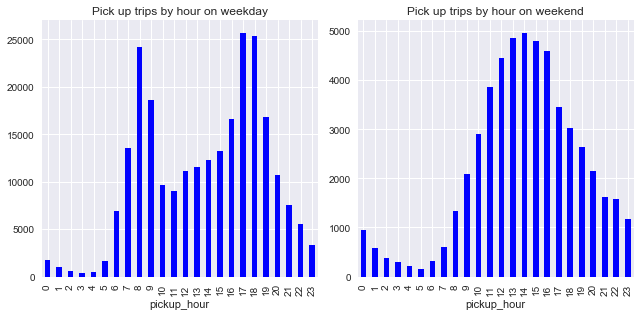

In [6]:
COL_NUM=2
ROW_NUM=1
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(9,4.5))

plt.subplot(1,2,1)
df_weekday=df[(df['day_of_week']!=6)&(df['day_of_week']!=7)]
group_weekday = df_weekday.groupby('pickup_hour')
group_weekday.size().plot(kind='bar',title="Pick up trips by hour on weekday",color='b')

plt.subplot(1,2,2)
df_weekend=df[(df['day_of_week']==6)|(df['day_of_week']==7)]
group_weekend = df_weekend.groupby('pickup_hour')
group_weekend.size().plot(kind='bar',title="Pick up trips by hour on weekend",color='b')

plt.tight_layout() 

# Busiest start and end stations

In [ ]:
# bar chart of start station density 
df.groupby('start station name').size().plot(kind='bar',title="start station density")
# filter out the top 5 start station with highest use density
df.groupby('end station name').size().sort_values(ascending=False)[0:5]

In [ ]:
# bar chart of end station density 
df.groupby('end station name').size().plot(kind='bar',title="end station density")
# filter out the top 5 end station with highest use density
df.groupby('end station name').size().sort_values(ascending=False)[0:5]

# Pick up density in Manhattan and outer borough

In [6]:
def if_Manhattan_station(latitude,longitude):
    
    # Separate Manhattan into five rectangles to check whether one given point in Manhattan or not.
    # In referrence to the bike distribution in https://member.citibikenyc.com/map/ and 
    
    a1=[(40.6997,40.7080),(-74.0200,-74.0003)]
    a2=[(40.7501,40.8445),(-73.9704,-73.9550)]
    a3=[(40.7080,40.8162),(-74.0200,-73.9704)]
    a4=[(40.7641,40.8445),(-73.9550,-73.9418)]
    a5=[(40.7836,40.8445),(-73.9418,-73.9273)] 
    a6=[(40.7232,40.7609),(-73.9846,-73.9639)]
    
    # Start checking
    if ((a1[0][0]<=latitude<=a1[0][1]) & (a1[1][0]<=longitude<=a1[1][1]))\
    or ((a2[0][0]<=latitude<=a2[0][1]) & (a2[1][0]<=longitude<=a2[1][1]))\
    or ((a3[0][0]<=latitude<=a3[0][1]) & (a3[1][0]<=longitude<=a3[1][1]))\
    or ((a4[0][0]<=latitude<=a4[0][1]) & (a4[1][0]<=longitude<=a4[1][1]))\
    or ((a5[0][0]<=latitude<=a5[0][1]) & (a5[1][0]<=longitude<=a5[1][1]))\
    or ((a6[0][0]<=latitude<=a6[0][1]) & (a6[1][0]<=longitude<=a6[1][1]))\
    or (latitude==40.750020)&(longitude==-73.969053): 
    
        return 1 # point within Manhattan
    else:
        return 0 # point out of Manhattan


<li>Trips by hour between Manhattan and outer borough on weekday

In [7]:
df_weekday=df[(df['day_of_week']!=6)&(df['day_of_week']!=7)]
# add column to check whether start and end station in Manhattan or not
df_weekday['if_start_Manhattan']=df_weekday.apply(lambda x: if_Manhattan_station(x['start station latitude'],x['start station longitude']),axis=1)
df_weekday['if_end_Manhattan']=df_weekday.apply(lambda x: if_Manhattan_station(x['end station latitude'],x['end station longitude']),axis=1)

df_weekday['stoptime'] = df_weekday['stoptime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_weekday['end_hour'] = df_weekday['stoptime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))

# separate trip according to direction(Manhattan<->outer borough)
df_Manhattan_out=df_weekday[(df_weekday['if_start_Manhattan']==1)&(df_weekday['if_end_Manhattan']==0)]
df_Manhattan_in=df_weekday[(df_weekday['if_start_Manhattan']==0)&(df_weekday['if_end_Manhattan']==1)]

# calculate number of trips per hour based on different directions.
out_count_byhour=dict()
for i in range(24):
    out_count_byhour[i]=df_Manhattan_out[(df_Manhattan_out['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_out['end_hour'])]['tripduration'].count()

in_count_byhour=dict()
for i in range(24):
    in_count_byhour[i]=df_Manhattan_in[(df_Manhattan_in['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_in['end_hour'])]['tripduration'].count()

/Users/chenyichang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chenyichang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/chenyichang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

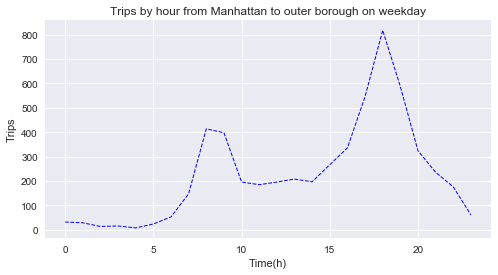

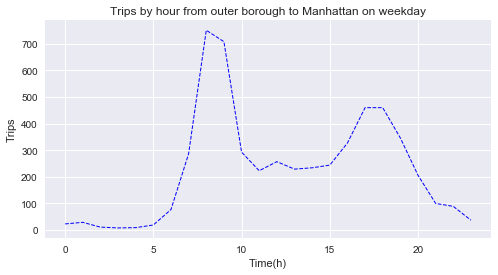

In [8]:
#Plot chart
x = out_count_byhour.keys()
y = out_count_byhour.values()
plt.figure(figsize=(8,4)) 
plt.plot(x,y,"b--",linewidth=1)
plt.xlabel("Time(h)") 
plt.ylabel("Trips") 
plt.title("Trips by hour from Manhattan to outer borough on weekday")
plt.show()

x = in_count_byhour.keys()
y = in_count_byhour.values()
plt.figure(figsize=(8,4)) 
plt.plot(x,y,"b--",linewidth=1)
plt.xlabel("Time(h)") 
plt.ylabel("Trips") 
plt.title("Trips by hour from outer borough to Manhattan on weekday")
plt.show()

<li>Trips by hour between Manhattan and outer borough on weekend

In [ ]:
df_weekend=df[(df['day_of_week']==6)|(df['day_of_week']==7)]

df_weekend['if_start_Manhattan']=df_weekend.apply(lambda x: if_Manhattan_station(x['start station latitude'],x['start station longitude']),axis=1)
df_weekend['if_end_Manhattan']=df_weekend.apply(lambda x: if_Manhattan_station(x['end station latitude'],x['end station longitude']),axis=1)

df_weekend['stoptime'] = df_weekend['stoptime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_weekend['end_hour'] = df_weekend['stoptime'].apply(lambda x:int(datetime.datetime.strftime(x,'%H')))

df_Manhattan_out=df_weekend[(df_weekend['if_start_Manhattan']==1)&(df_weekend['if_end_Manhattan']==0)]
df_Manhattan_in=df_weekend[(df_weekend['if_start_Manhattan']==0)&(df_weekend['if_end_Manhattan']==1)]

out_count_byhour=dict()
for i in range(24):
    out_count_byhour[i]=df_Manhattan_out[(df_Manhattan_out['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_out['end_hour'])]['tripduration'].count()

in_count_byhour=dict()
for i in range(24):
    in_count_byhour[i]=df_Manhattan_in[(df_Manhattan_in['pickup_hour']<=i)\
                                         &(i<=df_Manhattan_in['end_hour'])]['tripduration'].count()


/Users/chenyichang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chenyichang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/chenyichang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

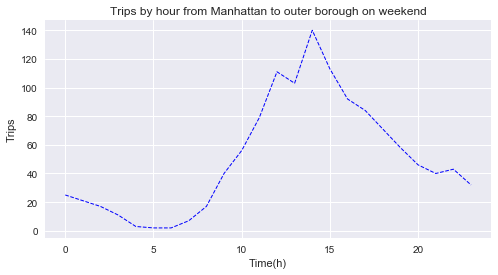

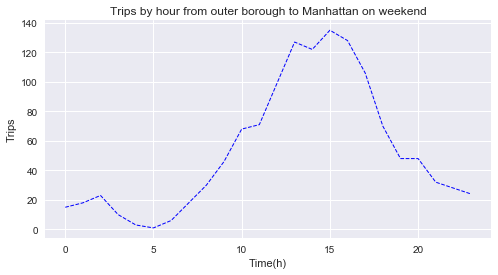

In [9]:
#Plot chart
x = out_count_byhour.keys()
y = out_count_byhour.values()
plt.figure(figsize=(8,4)) 
plt.plot(x,y,"b--",linewidth=1)
plt.xlabel("Time(h)") 
plt.ylabel("Trips") 
plt.title("Trips by hour from Manhattan to outer borough on weekend")
plt.show()

x = in_count_byhour.keys()
y = in_count_byhour.values()
plt.figure(figsize=(8,4)) 
plt.plot(x,y,"b--",linewidth=1)
plt.xlabel("Time(h)") 
plt.ylabel("Trips") 
plt.title("Trips by hour from outer borough to Manhattan on weekend")
plt.show()

# HeatMap WithTime of pick up density

In [7]:
df_weekday=df[(df['day_of_week']!=6)&(df['day_of_week']!=7)]

In [12]:
import folium
import folium.plugins as plugins
import numpy as np

df1=df_weekday.sample(n=20000)

# prepare latitude and longitude data per trip per hour
data=list()
for i in range(24):
    df_=df1[df1['pickup_hour']==i]
    data.append([[df_.iloc[j]['start station latitude'],df_.iloc[j]['start station longitude']]for j in range(len(df_))])

weight = 1  # default value
for time_entry in data:
    for row in time_entry:
        row.append(weight)


In [13]:
# plot heatmap with time
m = folium.Map([40.7204, -73.9280], tiles='stamentoner', zoom_start=12)

hm = plugins.HeatMapWithTime(data)

hm.add_to(m)

m

In [14]:
#match each fps to each hour
time_index = [
    'Time(hour): '+str(k)+':00'
    for k in range(24)
]
m = folium.Map([40.7204, -73.9280], tiles='stamentoner', zoom_start=12)

hm = plugins.HeatMapWithTime(
    data,
    index=time_index,
    auto_play=True,
)

hm.add_to(m)

m

# Analyze with network

<li>Define a function that returns two things:a graph and a dictionary with station ids as the key and station name as the value
</ol>
<li>The graph contains 
<ol>
<li>nodes (station ids)
<li>edges (station id, station id) (edge (x1,y1) is the same as (y1,x1))
<li>edge data 
<ol>
<li>count: number of trips on the edge
<li>time: average duration - pickup to dropoff - on that edge

In [ ]:
df['start station id'] = df['start station id'].apply(str)
df['end station id'] = df['end station id'].apply(str)

In [ ]:
def get_citibike_network(df):
    import networkx as nx
    %matplotlib inline
    import matplotlib.pyplot as plt
    G=nx.Graph()
    nodes=list()
    node_names = dict()
    
    # create node_names
    for i in df['start station id'].unique():
        node_names[i]=df[df['start station id']==i]['start station name'].iloc[0]
    for j in df['end station id'].unique():
        if j in node_names.keys():
            continue
        else:
            node_names[j]=df[df['end station id']==j]['end station name'].iloc[0]
    # add nodes
    G.add_nodes_from(node_names.keys())
    
    # redefine start_id and end_id so that edge (x1,y1) is the same as (y1,x1)
    df=df[df['start station id']!=df['end station id']]
    df['start id']=df.apply(lambda x: min(int(x['start station id']),int(x['end station id'])),axis=1)
    df['end id']=df.apply(lambda x: max(int(x['start station id']),int(x['end station id'])),axis=1)
    df['start id'] = df['start id'].apply(str)
    df['end id'] = df['end id'].apply(str)
    
    # calculate number of trips and average duration on the edge
    grouped = df.groupby(['start id','end id'])
    Avg=grouped['tripduration'].mean()
    Count=grouped['tripduration'].count()
    
    # add edges
    for i in Avg.index:
        G.add_edge(i[0],i[1],time=Avg[i])
    for j in Count.index:
        G.add_edge(j[0],j[1],count=Count[j])

        pos=nx.spring_layout(G) 

    # draw nodes
    nx.draw_networkx_nodes(G,pos,node_color='r',node_size=500,alpha=0.8)

    # draw edges
    nx.draw_networkx_edges(G,pos,edgelist=G.edges(),width=8,alpha=0.5,edge_color='b')

    node_name={}
    for node in G.nodes():
        node_name[node]=str(node)
    nx.draw_networkx_edge_labels(G,pos,font_size=10) #draw edge_label

    nx.draw_networkx_labels(G,pos,node_name,font_size=16)  #draw node_name

    plt.axis('off')
    plt.show() # display

    return G,node_names

# Build a regression model for prediction trip duration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

In [ ]:
df = pd.read_csv('201809-citibike-tripdata.csv')
df_copy = df
df.head()

In [ ]:
df.info()

In [ ]:
df = df.drop(df.index[(df['tripduration'] > 10800)])

In [ ]:
df_sample = df.sample(frac = 0.1, random_state = 0)

In [ ]:
df1=df
df1=df1.drop(['starttime'], axis = 1)
df1=df1.drop(['stoptime'], axis = 1)
df1=df1.drop(['start station name'], axis = 1)
df1=df1.drop(['end station name'], axis = 1)
df1=df1.drop(['start station id'], axis = 1)
df1=df1.drop(['end station id'], axis = 1)
df1=df1.drop(['bikeid'], axis = 1)
df1=df1.drop(['usertype'], axis = 1)
df1=df1.drop(['birth year'], axis = 1)
df1=df1.drop(['gender'], axis = 1)

In [ ]:
df1

In [ ]:
def distance(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 6373
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c
df1['distance'] = distance(df1['start station latitude'], df1['start station longitude'], 
                          df1['end station latitude'], df1['end station longitude'])

In [ ]:
df['distance'] = distance(df['start station latitude'], df['start station longitude'], 
                          df['end station latitude'], df['end station longitude'])

In [ ]:
df1=df1.drop(['start station latitude'], axis = 1)
df1=df1.drop(['end station latitude'], axis = 1)
df1=df1.drop(['start station longitude'], axis = 1)
df1=df1.drop(['end station longitude'], axis = 1)

In [ ]:
df1=pd.get_dummies(df1, drop_first = True)

In [ ]:
df1

# Lenear Regression Model

In [ ]:
X = df1.iloc[:,1:]  #Independent variable
y = df1.iloc[:,:1]   #Dependent variable

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

In [ ]:
df1.corr().loc[:,'tripduration']

In [ ]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

Plot the result of linear regression model

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X_test,y_test,color='darkgreen',label="Data", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
# plt.xlabel("Living Space (sqft)", fontsize=15)
# plt.ylabel("Price ($)", fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add back more variables

Since the accuracy of the model is not good enough, we add back more variables.

In [ ]:
df2 = df

df2.head()

In [ ]:
def distance(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 6373
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

df2['distance'] = distance(df2['start station latitude'], df2['start station longitude'], 
                           df2['end station latitude'], df2['end station longitude'])

In [ ]:
df2.corr()

In [ ]:
plot.pcolor(df.corr(),cmap='coolwarm') 
plot.show()

In [ ]:
df2=df
df2=df2.drop(['starttime'], axis = 1)
df2=df2.drop(['stoptime'], axis = 1)
df2=df2.drop(['start station name'], axis = 1)
df2=df2.drop(['end station name'], axis = 1)
df2=df2.drop(['start station id'], axis = 1)
df2=df2.drop(['end station id'], axis = 1)
df2=df2.drop(['bikeid'], axis = 1)
df2=df2.drop(['birth year'], axis = 1)
df2=df2.drop(['gender'], axis = 1)

In [ ]:
df2['user_type']=np.where(df['usertype']=='Subscriber',1,0)

In [ ]:
df2=df2.drop(['start station latitude'], axis = 1)
df2=df2.drop(['start station longitude'], axis = 1)
df2=df2.drop(['end station latitude'], axis = 1)
df2=df2.drop(['end station longitude'], axis = 1)

In [ ]:
df2

In [ ]:
X = df2.iloc[:,:2]  #Independent variable
y = df2.iloc[:,2:]   #Dependent variable

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

df1.corr().loc[:,'tripduration']

import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

# Random Forest

In [ ]:
df3 = df
def distance(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 6373
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

df3['distance'] = distance(df3['start station latitude'], df3['start station longitude'], 
                           df3['end station latitude'], df3['end station longitude'])
# df3=df
# df3=df3.drop(['starttime'], axis = 1)
# df3=df3.drop(['stoptime'], axis = 1)
df3=df3.drop(['start station name'], axis = 1)
df3=df3.drop(['end station name'], axis = 1)
# df3=df3.drop(['start station id'], axis = 1)
# df3=df3.drop(['end station id'], axis = 1)
# df3=df3.drop(['bikeid'], axis = 1)
# df3=df3.drop(['birth year'], axis = 1)
# df3=df3.drop(['gender'], axis = 1)

In [ ]:
df3=df3.drop(['starttime'], axis = 1)
df3=df3.drop(['stoptime'], axis = 1)
df3=df3.drop(['start station id'], axis = 1)
df3=df3.drop(['end station id'], axis = 1)
df3=df3.drop(['usertype'], axis = 1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor_rf = RandomForestRegressor(n_estimators = 4, random_state = 0, min_samples_leaf = 600)
regressor_rf.fit(X_train,y_train)
regressor_rf.score(X_test,y_test)

In [ ]:
%matplotlib inline
feature_names = [key for key in df]
importances = regressor_rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')

In [ ]:
importances

# Bicycles Exchanges Between Stations

## Finding bicycles that travel long distance and short distance

In [ ]:
bike_usage = df_bike.groupby('bikeid')[['distance']].sum()
low_use = bike_usage.sort_values(by=['distance']).index[0:int(len(bike_usage)/20)]  #Top 5 percent bicycles
high_use = bike_usage.sort_values(by=['distance']).index[4*int(len(bike_usage)/20):] #The lowest 5 percent bicycles

## Construct a function that can find the stations that highly used or rarely used bicycles frequently park

In [ ]:
def find_station(bike_use):
    station_usage1 = dict()
    station_usage2 = dict()
    for bike in bike_use:
        df1 = df_bike[df_bike.bikeid==bike].groupby('start station name').count()
        max_freq1 = df_bike[df_bike.bikeid==bike].groupby('start station name').size().max()
        for item in df1[df1['start station id'] == max_freq1].index:
            if item not in station_usage1:
                station_usage1[item] = 1
            else:
                station_usage1[item] += 1
        
        df2 = df_bike[df_bike.bikeid==bike].groupby('end station name').count()
        max_freq2 = df_bike[df_bike.bikeid==bike].groupby('end station name').size().max()
        for item in df2[df2['end station id'] == max_freq2].index:
            if item not in station_usage2:
                station_usage2[item] = 1
            else:
                station_usage2[item] += 1
        for item in station_usage2:
            if item not in station_usage1:
                station_usage1[item] = 1
            else:
                station_usage1[item] += station_usage2[item]
    return station_usage1

## Find the stations with top 5 frequency 

In [ ]:
h = find_station(high_use)
l = find_station(low_use)
print(sorted(h, key=h.__getitem__,reverse=True)[0:5])
print(sorted(l, key=l.__getitem__,reverse=True)[0:5])